In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%autosave 0
    
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

import os
import sys
import numpy as np
import pandas as pd
import sdata
import uuid
import time
import copy

#lets find databe.py
modulepath = os.path.dirname(os.getcwd())
sys.path.insert(0, os.path.abspath(os.path.join(modulepath)))

from sdata.contrib.simple_graph_db import Database

Autosave disabled


10:13:10 DEBUG:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
class Node():
    def __init__(self, name="N.N."):
        self.name = name
        self.uuid = uuid.uuid4().hex
        self.parent = None

    def copy(self, name=None):
        new_node = copy.deepcopy(self)
        new_node.uuid = uuid.uuid4().hex
        new_node.parent = self.uuid
        if name is not None:
            new_node.name = name
        return new_node

    @property
    def data(self):
        return {"name":self.name,
                "uuid":self.uuid,
                "!parent":self.parent}

    def __str__(self):
        return "{0.name}:{0.uuid}".format(self)

    __repr__ = __str__

In [3]:
nodes = []

n0 = Node("n0")
n01 = n0.copy("n01")
n02 = n0.copy("n02")
n011 = n01.copy("n011")
n012 = n01.copy("n012")
print(n0)
print(n01)
nodes.extend([n0, n01, n02, n011, n012])
print(nodes)

n0:838e5da99f5a479c8986d12df2475baa
n01:4f82d6d4ad5142bba3ebcf9a38febf8e
[n0:838e5da99f5a479c8986d12df2475baa, n01:4f82d6d4ad5142bba3ebcf9a38febf8e, n02:e8317adc94244cbaa220233b9ee9a960, n011:a0c491c96e9e4d31accd9c2073aa7b11, n012:278af390d9be48719acc95725a35cf73]


## initialize db

In [4]:

db_file = "/tmp/simple_graph_database.sqlite"
if os.path.exists(db_file):
    os.remove(db_file)

db = Database(db_file=db_file)
print(db)

db.add_node(data={"a":1}, identifier=None)

(DB:'/tmp/simple_graph_database.sqlite')


'0c41cb4c3a8844798faba2336e5e0370'

## add nodes

In [5]:
for node in nodes:
    db.add_node(identifier=node.uuid, data=node.data)

In [6]:
db.find_node(node.uuid)

{'name': 'n012',
 'uuid': '278af390d9be48719acc95725a35cf73',
 '!parent': '4f82d6d4ad5142bba3ebcf9a38febf8e',
 'id': '278af390d9be48719acc95725a35cf73'}

## add edges

In [7]:
for node in nodes:
    if node.parent is not None and node.uuid is not None:
        print("{} -> {}".format(node.parent, node.uuid))
        db.connect_nodes(node.parent, node.uuid, {'parent': node.parent})


838e5da99f5a479c8986d12df2475baa -> 4f82d6d4ad5142bba3ebcf9a38febf8e
838e5da99f5a479c8986d12df2475baa -> e8317adc94244cbaa220233b9ee9a960
4f82d6d4ad5142bba3ebcf9a38febf8e -> a0c491c96e9e4d31accd9c2073aa7b11
4f82d6d4ad5142bba3ebcf9a38febf8e -> 278af390d9be48719acc95725a35cf73


## get node by uuid

In [8]:
rn0 = db.find_node(n0.uuid)
print(rn0)
assert n0.uuid == rn0.get("uuid")

{'name': 'n0', 'uuid': '838e5da99f5a479c8986d12df2475baa', '!parent': None, 'id': '838e5da99f5a479c8986d12df2475baa'}


## get all nodes

In [9]:
db.find_nodes({'name': ''})

[{'name': 'n0',
  'uuid': '838e5da99f5a479c8986d12df2475baa',
  '!parent': None,
  'id': '838e5da99f5a479c8986d12df2475baa'},
 {'name': 'n01',
  'uuid': '4f82d6d4ad5142bba3ebcf9a38febf8e',
  '!parent': '838e5da99f5a479c8986d12df2475baa',
  'id': '4f82d6d4ad5142bba3ebcf9a38febf8e'},
 {'name': 'n02',
  'uuid': 'e8317adc94244cbaa220233b9ee9a960',
  '!parent': '838e5da99f5a479c8986d12df2475baa',
  'id': 'e8317adc94244cbaa220233b9ee9a960'},
 {'name': 'n011',
  'uuid': 'a0c491c96e9e4d31accd9c2073aa7b11',
  '!parent': '4f82d6d4ad5142bba3ebcf9a38febf8e',
  'id': 'a0c491c96e9e4d31accd9c2073aa7b11'},
 {'name': 'n012',
  'uuid': '278af390d9be48719acc95725a35cf73',
  '!parent': '4f82d6d4ad5142bba3ebcf9a38febf8e',
  'id': '278af390d9be48719acc95725a35cf73'}]

In [10]:
db.find_nodes({'id': '97'})

[]

In [11]:
rn011 = db.find_node(n011.uuid)
print(rn011)
assert n011.uuid == rn011.get("uuid")
assert n011.parent == rn011.get("!parent")

{'name': 'n011', 'uuid': 'a0c491c96e9e4d31accd9c2073aa7b11', '!parent': '4f82d6d4ad5142bba3ebcf9a38febf8e', 'id': 'a0c491c96e9e4d31accd9c2073aa7b11'}


In [12]:
import pygraphviz as pgv
from IPython.display import Image

def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

In [13]:
ids = [n.uuid for n in nodes]
print(ids)

dotstr = db.get_dot(path=ids)
print("!", dotstr)

['838e5da99f5a479c8986d12df2475baa', '4f82d6d4ad5142bba3ebcf9a38febf8e', 'e8317adc94244cbaa220233b9ee9a960', 'a0c491c96e9e4d31accd9c2073aa7b11', '278af390d9be48719acc95725a35cf73']
! digraph {
"838e5da99f5a479c8986d12df2475baa" [label="name n0\nuuid 838e5da99f5a479c8986d12df2475baa\nparent None"];
"838e5da99f5a479c8986d12df2475baa" -> "4f82d6d4ad5142bba3ebcf9a38febf8e" [label=""];
"838e5da99f5a479c8986d12df2475baa" -> "e8317adc94244cbaa220233b9ee9a960" [label=""];
"4f82d6d4ad5142bba3ebcf9a38febf8e" [label="name n01\nuuid 4f82d6d4ad5142bba3ebcf9a38febf8e\nparent 838e5da99f5a479c8986d12df2475baa"];
"4f82d6d4ad5142bba3ebcf9a38febf8e" -> "a0c491c96e9e4d31accd9c2073aa7b11" [label=""];
"4f82d6d4ad5142bba3ebcf9a38febf8e" -> "278af390d9be48719acc95725a35cf73" [label=""];
"e8317adc94244cbaa220233b9ee9a960" [label="name n02\nuuid e8317adc94244cbaa220233b9ee9a960\nparent 838e5da99f5a479c8986d12df2475baa"];
"a0c491c96e9e4d31accd9c2073aa7b11" [label="name n011\nuuid a0c491c96e9e4d31accd9c2073aa7b11

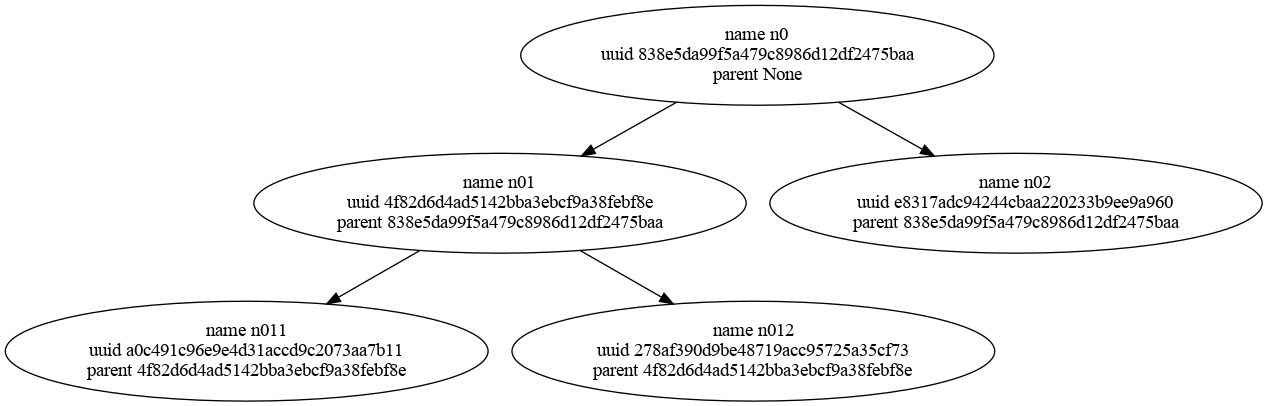

In [14]:
draw(dotstr)


In [15]:
db.visualize(path=ids)

'simple_graph.dot'

In [16]:
cat simple_graph.dot


digraph {
"838e5da99f5a479c8986d12df2475baa" [label="name n0\nuuid 838e5da99f5a479c8986d12df2475baa\nparent None"];
"4f82d6d4ad5142bba3ebcf9a38febf8e" [label="name n01\nuuid 4f82d6d4ad5142bba3ebcf9a38febf8e\nparent 838e5da99f5a479c8986d12df2475baa"];
"e8317adc94244cbaa220233b9ee9a960" [label="name n02\nuuid e8317adc94244cbaa220233b9ee9a960\nparent 838e5da99f5a479c8986d12df2475baa"];
"a0c491c96e9e4d31accd9c2073aa7b11" [label="name n011\nuuid a0c491c96e9e4d31accd9c2073aa7b11\nparent 4f82d6d4ad5142bba3ebcf9a38febf8e"];
"278af390d9be48719acc95725a35cf73" [label="name n012\nuuid 278af390d9be48719acc95725a35cf73\nparent 4f82d6d4ad5142bba3ebcf9a38febf8e"];
"838e5da99f5a479c8986d12df2475baa" -> "4f82d6d4ad5142bba3ebcf9a38febf8e" [label="parent 838e5da99f5a479c8986d12df2475baa"];
}


In [17]:
db.find_neighbors(n01.uuid)

[('4f82d6d4ad5142bba3ebcf9a38febf8e',
  'a0c491c96e9e4d31accd9c2073aa7b11',
  '{"parent":"4f82d6d4ad5142bba3ebcf9a38febf8e"}'),
 ('4f82d6d4ad5142bba3ebcf9a38febf8e',
  '278af390d9be48719acc95725a35cf73',
  '{"parent":"4f82d6d4ad5142bba3ebcf9a38febf8e"}'),
 ('838e5da99f5a479c8986d12df2475baa',
  '4f82d6d4ad5142bba3ebcf9a38febf8e',
  '{"parent":"838e5da99f5a479c8986d12df2475baa"}')]

In [18]:
db.find_neighbors(n02.uuid)

[('838e5da99f5a479c8986d12df2475baa',
  'e8317adc94244cbaa220233b9ee9a960',
  '{"parent":"838e5da99f5a479c8986d12df2475baa"}')]

In [19]:
db.remove_node(n011.uuid)

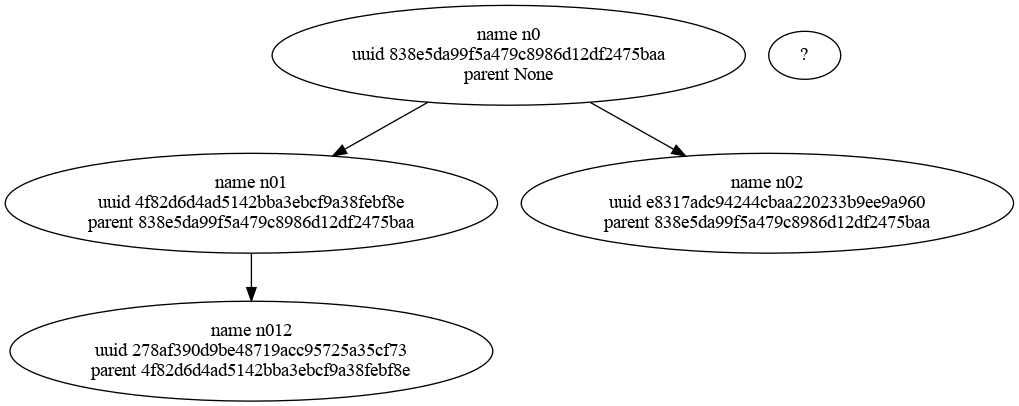

In [20]:
dotstr = db.get_dot(path=ids)
draw(dotstr)

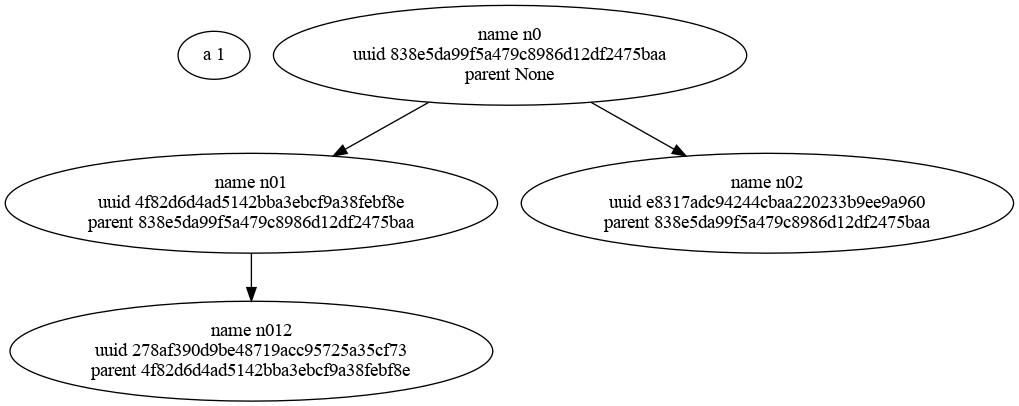

In [21]:
dotstr = db.get_dot(path=db.get_all_node_ids())
draw(dotstr)

In [22]:
db.get_all_edges()

[('838e5da99f5a479c8986d12df2475baa',
  '4f82d6d4ad5142bba3ebcf9a38febf8e',
  '{"parent":"838e5da99f5a479c8986d12df2475baa"}'),
 ('838e5da99f5a479c8986d12df2475baa',
  'e8317adc94244cbaa220233b9ee9a960',
  '{"parent":"838e5da99f5a479c8986d12df2475baa"}'),
 ('4f82d6d4ad5142bba3ebcf9a38febf8e',
  '278af390d9be48719acc95725a35cf73',
  '{"parent":"4f82d6d4ad5142bba3ebcf9a38febf8e"}')]